<a href="https://colab.research.google.com/github/suryogumilar/tensorflow_playground/blob/main/C1_W4_Lab_1_image_generator_no_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training with ImageDataGenerator

In [ ]:
#Run the code below to download the compressed dataset horse-or-human.zip
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip


--2022-11-24 07:37:53--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M  15.6MB/s    in 11s     

2022-11-24 07:38:04 (13.4 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]



In [ ]:
import zipfile
import os, signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import random
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
# Unzip the dataset
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')
zip_ref.close()

In [ ]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

print(train_horse_dir)
print(train_human_dir)
print(type(train_horse_dir))

train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

./horse-or-human/horses
./horse-or-human/humans
<class 'str'>
['horse35-8.png', 'horse39-4.png', 'horse01-5.png', 'horse42-1.png', 'horse46-6.png', 'horse20-0.png', 'horse42-2.png', 'horse17-1.png', 'horse23-3.png', 'horse37-0.png']
['human01-24.png', 'human07-05.png', 'human14-23.png', 'human16-22.png', 'human08-01.png', 'human01-14.png', 'human02-16.png', 'human16-12.png', 'human12-11.png', 'human07-17.png']
total training horse images: 500
total training human images: 527


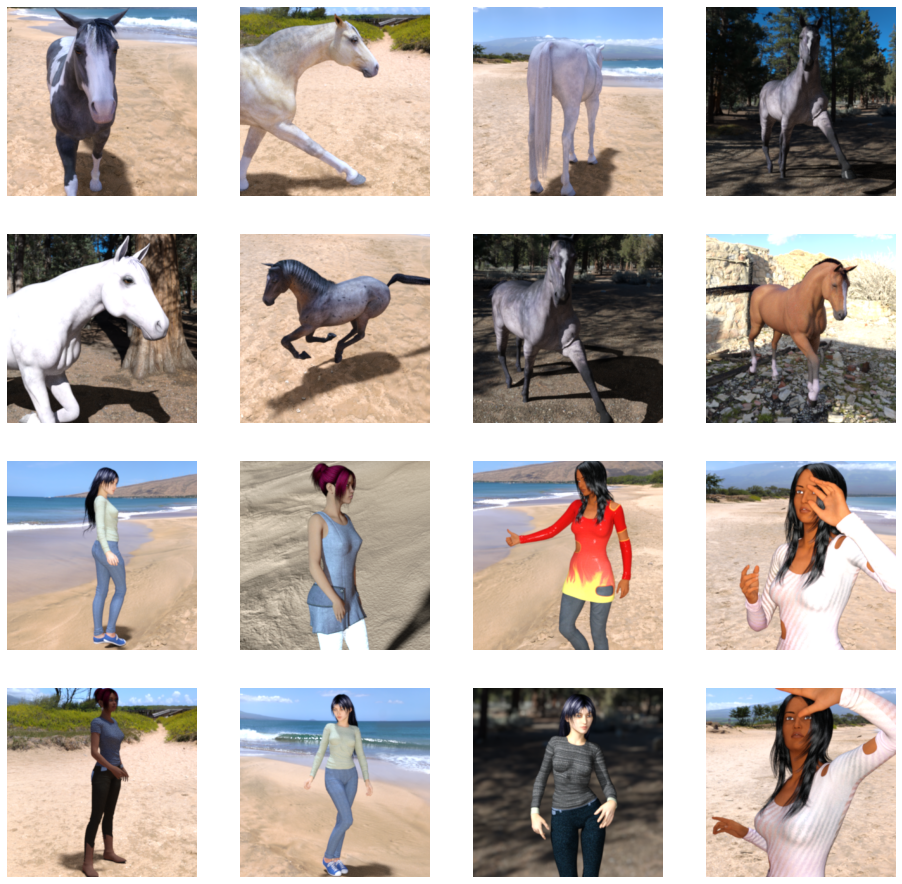

In [ ]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Building a Small Model from Scratch

In [ ]:
## set seed so that model has same 'common ground' (it node's weight and bias are the same value on each creation)
tf.random.set_seed(10)


model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### rescale using 1/255

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.


### steps_per_epoch=8 ?

in the previous step there are 1027 images and using parameter `batch_size=128` means we are loading them in 128 images at a time (or each batch contains 128 images)

so this means 1027/128 = 8.023 steps per epoch in order to load them all (or maybe we can make it 9?)

```
steps_per_epoch = number of dataset / batch_size
```

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 18s 964ms/step - loss: 1.3377 - accuracy: 0.5150
Epoch 2/15
8/8 [==============================] - 7s 783ms/step - loss: 0.6086 - accuracy: 0.6719
Epoch 3/15
8/8 [==============================] - 6s 764ms/step - loss: 0.8730 - accuracy: 0.6151
Epoch 4/15
8/8 [==============================] - 6s 779ms/step - loss: 0.4435 - accuracy: 0.8376
Epoch 5/15
8/8 [==============================] - 6s 778ms/step - loss: 0.3590 - accuracy: 0.8843
Epoch 6/15
8/8 [==============================] - 7s 781ms/step - loss: 0.2059 - accuracy: 0.9232
Epoch 7/15
8/8 [==============================] - 7s 784ms/step - loss: 0.6012 - accuracy: 0.8076
Epoch 8/15
8/8 [==============================] - 7s 794ms/step - loss: 0.2270 - accuracy: 0.9032
Epoch 9/15
8/8 [==============================] - 7s 797ms/step - loss: 0.1095 - accuracy: 0.9655
Epoch 10/15
8/8 [==============================] - 7s 1s/step - loss: 0.0445 - accuracy: 0.9822
Epoch 11/15
8/8 [====

In [ ]:
def plot_history(history):

  # summarize history for loss
  plt.plot(history.history['loss'])
  #plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  #plt.legend(['train', 'test'], loc='upper left')
  plt.legend(['train'], loc='upper left')
  plt.show()


  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  #plt.plot(history.history['val_sparse_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  #plt.legend(['train', 'test'], loc='upper left')
  plt.legend(['train'], loc='upper left')
  plt.show()

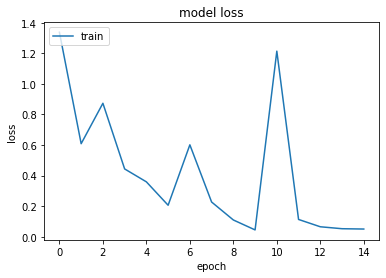

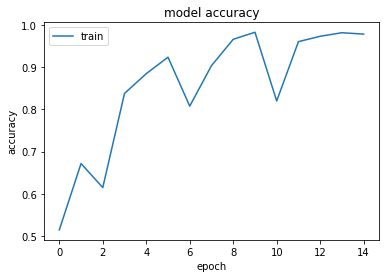

In [ ]:
plot_history(history)

## Model Prediction

Saving horseinsuit2 (1).jpg to horseinsuit2 (1) (1).jpg
1/1 [==============================] - 0s 18ms/step
[0.06009844]
horseinsuit2 (1).jpg is a horse


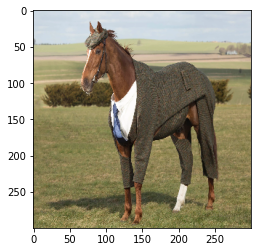

In [ ]:
## CODE BLOCK FOR NON-SAFARI BROWSERS
## SAFARI USERS: PLEASE SKIP THIS BLOCK AND RUN THE NEXT ONE INSTEAD

import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
    
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
  plt.imshow(img)

Saving centaur_still.jpg to centaur_still.jpg
1/1 [==============================] - 0s 17ms/step
[1.]
centaur_still.jpg is a human


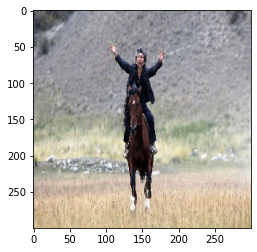

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
    
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
  plt.imshow(img)

Saving i-am-belph-basliksiz-2.jpg to i-am-belph-basliksiz-2.jpg
1/1 [==============================] - 0s 20ms/step
[5.797509e-09]
i-am-belph-basliksiz-2.jpg is a horse


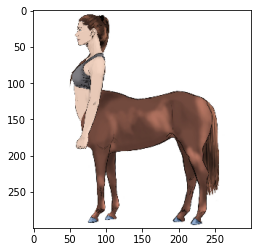

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
    
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
  plt.imshow(img)

Saving 1648656065078.jpg to 1648656065078.jpg
1/1 [==============================] - 0s 19ms/step
[0.98853135]
1648656065078.jpg is a human


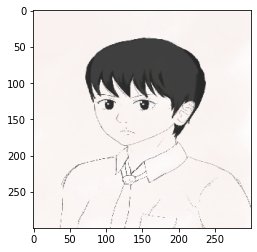

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
    
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
  plt.imshow(img)

1/1 [==============================] - 0s 94ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


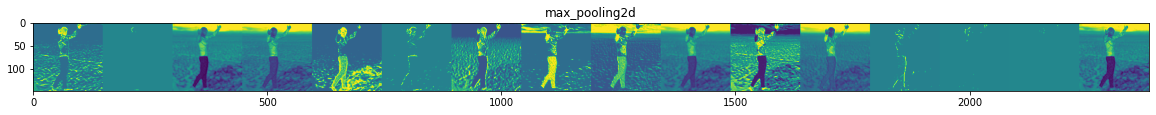

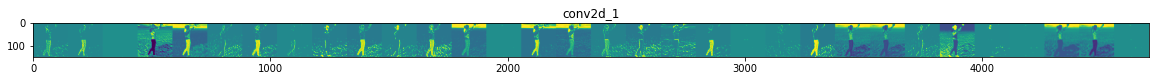

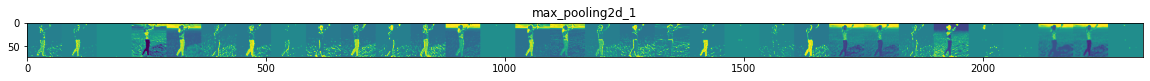

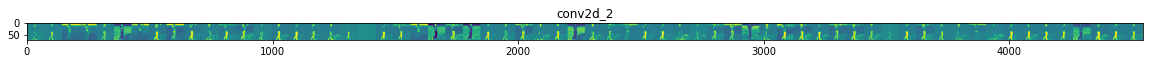

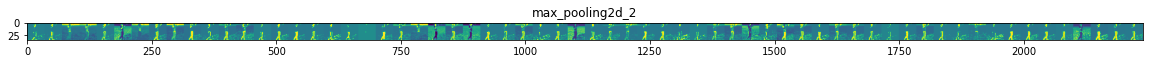

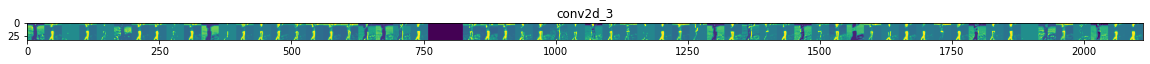

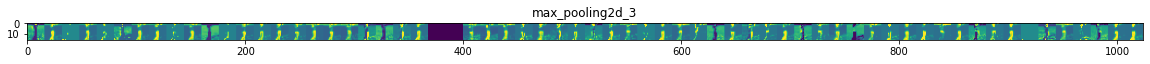

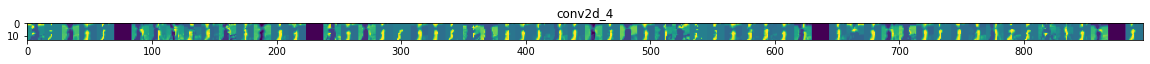

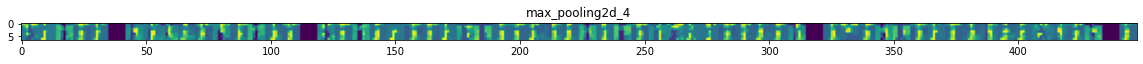

In [ ]:
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
    
      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Saving 1648656065078.jpg to 1648656065078 (2).jpg
1/1 [==============================] - 0s 89ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


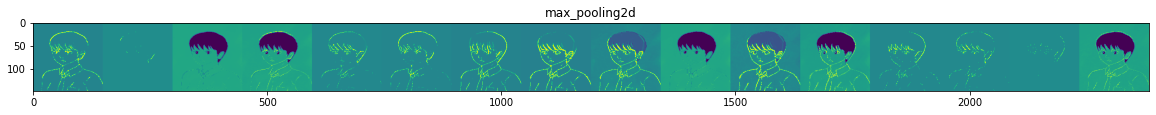

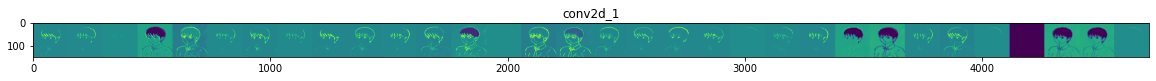

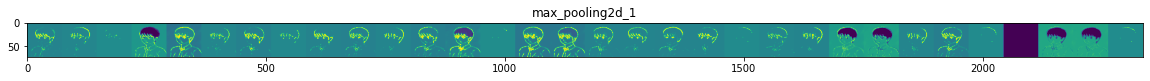

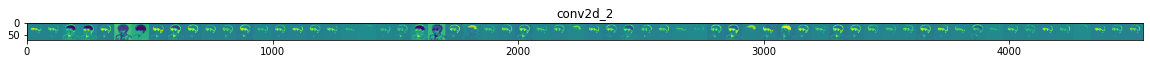

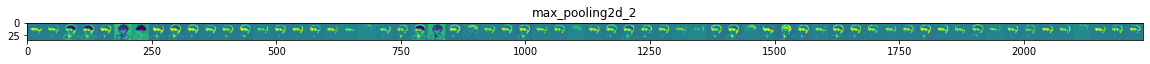

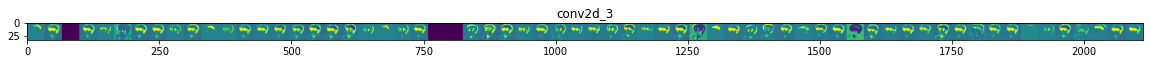

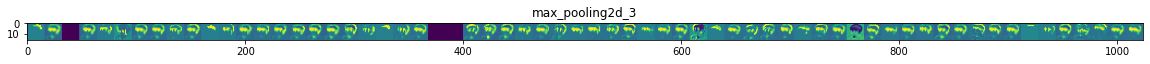

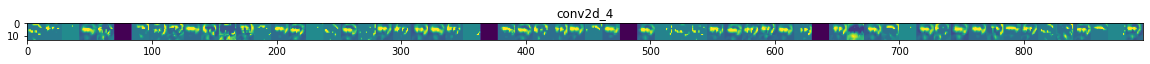

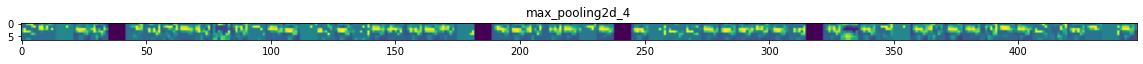

In [ ]:
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)


uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
  x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

  # Scale by 1/255
  x /= 255

  # Run the image through the network, thus obtaining all
  # intermediate representations for this image.
  successive_feature_maps = visualization_model.predict(x)

  # These are the names of the layers, so you can have them as part of the plot
  layer_names = [layer.name for layer in model.layers[1:]]

  # Display the representations
  for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:

      # Just do this for the conv / maxpool layers, not the fully-connected layers
      n_features = feature_map.shape[-1]  # number of features in feature map

      # The feature map has shape (1, size, size, n_features)
      size = feature_map.shape[1]
    
      # Tile the images in this matrix
      display_grid = np.zeros((size, size * n_features))
      for i in range(n_features):
        x = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std()
        x *= 64
        x += 128
        x = np.clip(x, 0, 255).astype('uint8')
    
        # Tile each filter into this big horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x
    
      # Display the grid
      scale = 20. / n_features
      plt.figure(figsize=(scale * n_features, scale))
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='viridis')

You can see above how the pixels highlighted turn to increasingly abstract and compact representations, especially at the bottom grid.

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called representation sparsity and is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline wherein each layer filters out the most useful features.

In [ ]:
#import os, signal
#os.kill(os.getpid(), signal.SIGKILL)